```-

File:           ohlc_resnet_clf.py
Description:    ResNet18 binary classification model
Author:         Morgan Cooper
Created:        2025-09-01
Updated:        2025-09-09

Notes:

Attempts to classify candle charts by future up moves vs down moves.

```

In [1]:
import sys; sys.path.append("../..")
from torch.utils.data import Dataset, DataLoader
from iterations.iteration_001.get_ohlc_data import OHLCImageDataset
from sklearn.model_selection import train_test_split
from torchvision.models import (
    resnet18, 
    ResNet18_Weights, 
    resnet50, 
    ResNet50_Weights
)
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import pandas as pd
import numpy as np
from torch import nn
import torch

df = pd.read_csv("../../data/ohlc_images/window=180/meta.csv")

train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    shuffle=False
)

split_idx = len(temp_df) // 2
val_df  = temp_df.iloc[:split_idx].reset_index(drop=True)
test_df = temp_df.iloc[split_idx:].reset_index(drop=True)

train_img_paths = train_df["path"].tolist()
val_img_paths   = val_df["path"].tolist()
test_img_paths  = test_df["path"].tolist()

train_labels = train_df["label"].tolist()
val_labels   = val_df["label"].tolist()
test_labels  = test_df["label"].tolist()

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 5691 | Val: 1220 | Test: 1220


In [2]:
print("Train distribution:")
print(train_df["label"].value_counts(normalize=True))
print(train_df["label"].value_counts())              

print("\nValidation distribution:")
print(val_df["label"].value_counts(normalize=True))
print(val_df["label"].value_counts())

print("\nTest distribution:")
print(test_df["label"].value_counts(normalize=True))
print(test_df["label"].value_counts())


Train distribution:
label
1    0.533474
0    0.466526
Name: proportion, dtype: float64
label
1    3036
0    2655
Name: count, dtype: int64

Validation distribution:
label
1    0.533607
0    0.466393
Name: proportion, dtype: float64
label
1    651
0    569
Name: count, dtype: int64

Test distribution:
label
1    0.536066
0    0.463934
Name: proportion, dtype: float64
label
1    654
0    566
Name: count, dtype: int64


In [3]:
tfm = transforms.Compose(
    [   
        transforms.Resize((220, 220)),
        transforms.ToTensor(), 
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            ),
    ]
)

train_ds = OHLCImageDataset(image_paths=train_img_paths, labels=train_labels, transform=tfm)
val_ds = OHLCImageDataset(image_paths=val_img_paths, labels=val_labels, transform=tfm)
test_ds = OHLCImageDataset(image_paths=test_img_paths, labels=test_labels, transform=tfm)

train_loader = DataLoader(dataset=train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=16, shuffle=False)


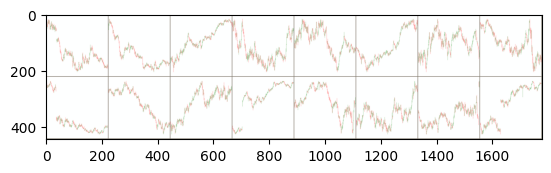

1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1


In [5]:
classes = (0, 1)

def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = std * npimg + mean 
    npimg = np.clip(npimg, 0, 1) 
    plt.imshow(npimg)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(16)))

In [6]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(512, 2)
for name, param in model.named_parameters():
    if name.startswith(("conv1", "bn1", 
                        "layer1", 
                        "layer2", 
                        "layer3"
                        )):
        param.requires_grad = False
        

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-5},
    {"params": model.fc.parameters(),     "lr": 1e-4},
], weight_decay=1e-4)


In [7]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"\nEPOCH: {epoch+1}")

    # ---- TRAINING ----
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    print(f'  [batch {i:5d}] train loss: {avg_train_loss:.3f}')

    running_loss = 0.0
    
    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader: 
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    print(f"  Validation loss: {avg_val_loss:.3f}, acc: {val_acc:.2f}%")


EPOCH: 1
  [batch   356] train loss: 0.707
  Validation loss: 0.714, acc: 52.21%

EPOCH: 2
  [batch   356] train loss: 0.646
  Validation loss: 0.722, acc: 51.23%

EPOCH: 3
  [batch   356] train loss: 0.591
  Validation loss: 0.728, acc: 50.49%

EPOCH: 4
  [batch   356] train loss: 0.514
  Validation loss: 0.763, acc: 50.82%

EPOCH: 5
  [batch   356] train loss: 0.408
  Validation loss: 0.815, acc: 50.00%


In [ ]:
# ---- TEST ----
test_loss = 0.0
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_acc = 100.0 * test_correct / test_total

print(f"  Test loss: {avg_test_loss:.3f}, acc: {test_acc:.2f}%")

  Test loss: 0.697, acc: 51.97%


In [ ]:
import torch
import pandas as pd
import numpy as np

# ---- PROBA BINNING ON VALIDATION SET ----
model.eval()
test_probs = []
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # assume raw logits
        probs = torch.softmax(outputs, dim=1)[:, 1]  # P(class=1)
        preds = torch.argmax(outputs, dim=1)

        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_df = pd.DataFrame({
    "proba": test_probs,
    "pred": test_preds,
    "label": test_labels
})

test_df["bin"] = pd.qcut(test_df["proba"], q=20, labels=False)

bin_stats = test_df.groupby("bin").agg(
    avg_proba=("proba", "mean"),
    accuracy=("pred", lambda x: (x == test_df.loc[x.index, "label"]).mean()),
    win_rate=("label", "mean"),
    count=("label", "count")
).reset_index()

bin_stats["num_won"] = (bin_stats["win_rate"] * bin_stats["count"]).astype(int)
bin_stats = bin_stats.rename(columns={"count": "num_total"})
bin_stats_sorted = bin_stats.sort_values("avg_proba", ascending=False).reset_index(drop=True)
bin_stats_sorted["bin_pctile"] = bin_stats_sorted.index.map(lambda i: f"{(20 - i) * 5}%")

final_test_bin_stats = bin_stats_sorted[[
    "bin_pctile", "avg_proba", "accuracy", "num_total", "num_won"
]]

print("\nTEST BINNING STATS (sorted by confidence):")
print(final_test_bin_stats)



TEST BINNING STATS (sorted by confidence):
   bin_pctile  avg_proba  accuracy  num_total  num_won
0        100%   0.709488  0.622951         61       38
1         95%   0.665405  0.540984         61       33
2         90%   0.637869  0.524590         61       32
3         85%   0.620620  0.590164         61       36
4         80%   0.604219  0.639344         61       39
5         75%   0.590398  0.508197         61       31
6         70%   0.577928  0.508197         61       31
7         65%   0.566974  0.590164         61       36
8         60%   0.555456  0.524590         61       32
9         55%   0.544703  0.557377         61       34
10        50%   0.533688  0.573770         61       35
11        45%   0.522163  0.393443         61       24
12        40%   0.508909  0.442623         61       27
13        35%   0.495469  0.426230         61       35
14        30%   0.484579  0.475410         61       32
15        25%   0.469257  0.508197         61       30
16        20%   0.453